In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw

In [ ]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/wSal_Linear_minhs'
case_id = 1
State01 = xr.open_dataset(path1 + '/state_' + str(format(case_id,'03d')) + '.nc')    
State = State01.isel(T=~State01.get_index("T").duplicated())
state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))
u = state.U.data[1,:,:,2].mean(1)
s = state.S.data[2,:,:,6].mean(1)
pt = state.Temp.data[2,:,:,6].mean(1)
depth = state.Z.data
pres = gsw.p_from_z(depth, 55)

In [ ]:
u
#depth[u==u.max()], u.max(), u.min()

In [ ]:
def layer_Nsquare(datapath, case_id, xidx):
    
    State01 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))

    # Potential temp
    Ttz = state.Temp.data[:,:,:,xidx].mean(2)
    
    # Salinity
    Stz = state.S.data[:,:,:,xidx].mean(2)
    
    depth = state.Z.data
    time = state.T.data / 86400 # Time in days
    
    # Pressure
    pres = gsw.p_from_z(depth, 55)    
    p = np.tile(pres,[len(time),1])
    
    N2 = np.empty(len(time))
    for i in range(len(time)):
        N, Pmid = gsw.Nsquared(Stz[i,:],Ttz[i,:],pres,55)
        N2[i] = N.mean()
    
    return time, N2

In [2]:
def plume_height(datapath, case_id):
    
    State01 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')    
    State = State01.isel(T=~State01.get_index("T").duplicated())
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))
    
    xidx = 2 # Glacier front index
    
    # Along-fjord velocity
    u = state.U.data[1,:,:,xidx].mean(1)
    
    # Potential temp
    T0 = state.Temp.data[0,:,:,xidx].mean(1)
    
    # Salinity
    S0 = state.S.data[0,:,:,xidx].mean(1)
    
    depth = state.Z.data  
    # Pressure
    pres = gsw.p_from_z(depth, 55)

    N2, Pmid = gsw.Nsquared(S0,T0,pres,55)
    
    rho = gsw.rho(S0, T0, pres)
    rho_a = rho[-1] # Ambient density
    
    ph_obs = 400 + depth[u==u.max()]
    
    return ph_obs, N2.mean(), rho_a

In [ ]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'

# day, bfreq1 = layer_Nsquare(path1, 1, 6)
# day, bfreq2 = layer_Nsquare(path1, 4, 6)

In [ ]:
fig1 = plt.figure(figsize=(12,4))
fig1.tight_layout()

ax1 = fig1.add_subplot(111)
#ax1.axvline(x=0,color='k',linestyle=':')
plt.grid(linestyle = '--', linewidth = 0.5)
ax1.plot(day,bfreq1*1e4,'b-',lw=2,label=r'$4\frac{\partial S_0}{\partial z}$')
ax1.plot(day,bfreq2*1e4,'r-',lw=2,label=r'$1\frac{\partial S_0}{\partial z}$')
ax1.legend(loc='best',fontsize=15)
ax1.set_ylabel(r'$N^2$ [$\times10^{-4}\,s^{-2}$]', size=15)
ax1.set_xlabel(r'Time [days]', size=15)
#ax1.set_title('(a)', loc='left', size=15, weight='bold')
ax1.tick_params(direction='in', labelsize=15)

In [3]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Sal_Linear_minhs'

case = np.array([5,4,3,2,1])
h_obs = np.empty(len(case))
N2 = np.empty(len(case))
rhoa = np.empty(len(case))
for i in range(len(case)):
    h_obs[i], N2[i], rhoa[i] = plume_height(path1, case[i])

# Prediction of plume height
g = 9.81
Qsg = 250
a = 0.1 # Entrainment coef
rho_ref = 1020 # Reference density
rhop = 1000 # Plume density
gr = g * (rhoa-rhop)/rho_ref # Reduced gravity
#h_est = ((g*Qsg)**(1/4)) * ((N2)**(-3/8))
h_bpt = ((gr*Qsg/(2*np.pi*a*a))**(1/4)) * ((N2)**(-3/8)) # Estimate based on Buoyant Plume Theory
z0 = h_obs / h_bpt
h_est = h_bpt * z0.mean()
h = 400 # Fjord depth
h_est[h_est>h] = h

In [4]:
#h_obs, h_est, N2
corr_matrix1 = np.corrcoef(h_obs,h_est)
corr1 = corr_matrix1[0,1]
R_sq1 = corr1**2
print(R_sq1)

0.9919274495560465


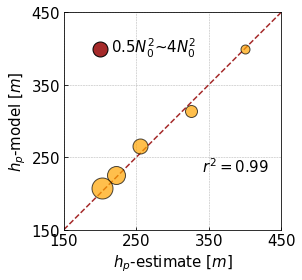

In [5]:
fig2, ax2 =plt.subplots(figsize=(4,4))


ax2.set(xlim=(150, 450), ylim=(150, 450))
plt.axis('square')
plt.grid(ls='--', lw=.5)
plt.xlabel(r'$h_{p}$-estimate [$m$]', size=15)
plt.ylabel(r'$h_{p}$-model [$m$]', size=15)
ax2.set_xticks([150, 250, 350, 450])
ax2.set_yticks([150, 250, 350, 450])
#ax2.set_title(r'$T_{fjord}/T_{shelf}$', size=15)
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", lw=1.5, c="brown")
ax2.tick_params(direction='in', labelsize=15)
loc_mark = [200, 400]
plt.plot(loc_mark[0],loc_mark[1], marker='o', alpha=1, ms=15, color='brown', markeredgecolor='k')
plt.text(loc_mark[0]+15, loc_mark[1]-5, r'$0.5N_0^2$~$4N_0^2$', fontsize=15)
plt.text(340, 230, r'$r^2=0.99$', fontsize=15)

#for side in ax2.spines.keys():  # 'top', 'bottom', 'left', 'right'
#    ax2.spines[side].set_linewidth(1.5)
#    ax2.spines[side].set_color('red')

for j in range(len(case)):

    ax2.plot(h_est[j], h_obs[j], marker='o', alpha=.7, ms=3*(j+3), color='orange', markeredgecolor='k')



In [6]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
#fig1.savefig(fig_path + '/Strat_N2.png', dpi=300, bbox_inches='tight')
fig2.savefig(fig_path + '/plume_height.png', dpi=300, bbox_inches='tight') 